In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.models import Model
from keras.utils import to_categorical

In [2]:
# function to load dataset from keras
def load_dataset(name):
    # load dataset
    (trainX, trainY), (testX, testY) = name.load_data()
    # shape of dataset
    train_shape, test_shape = [trainX.shape, trainY.shape], [testX.shape, testY.shape]
    num_classes = len(np.unique(trainY))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY, train_shape, test_shape

In [3]:
# processing the data
def data_process(trainX, testX):
    # convert from integers to floats
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    # normalize to range 0-1
    trainX = trainX / 255.0
    testX = testX / 255.0
    trainX = trainX.reshape((len(trainX), np.prod(trainX.shape[1:])))
    testX = testX.reshape((len(testX), np.prod(testX.shape[1:])))
    # return normalized images
    return trainX, testX

In [4]:
trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)
x_train , x_test = data_process(trainX, testX)

In [5]:
# model architecture
def auto_model(neurons):
    input_img = Input(shape=(784,))
    # encoders
    encoded = Dense(256, activation='relu')(input_img)
    encoded = Dense(128, activation='relu')(encoded)
    # feature representation
    encoded = Dense(neurons, activation='relu')(encoded)
    # decoders
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [6]:
from keras.regularizers import l2

def classification_model(input_size):
    # define model
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=input_size, kernel_regularizer=l2(0.01)))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def diagnostic_plots(history):
    # plot for loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='red', label='train')
    plt.plot(history.history['val_loss'], color='blue', label='test')
    plt.legend()
    # plot for accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='red', label='train')
    plt.plot(history.history['val_accuracy'], color='blue', label='test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def plot_encoded(encoder, x_test, size):
    encoded_imgs = encoder.predict(x_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original x_test
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        if encoded_imgs[i].shape[0] == size:  # Check if the encoded image can be reshaped to (8, 8)
            # display encoded_imgs
            reshape_size = int(np.sqrt(size))
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(encoded_imgs[i].reshape(reshape_size, reshape_size))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            print(f"Cannot reshape encoded image {i} to (8, 8). Its shape is {encoded_imgs[i].shape}")
    plt.show()

In [9]:
def display_output(images, decoded_images):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
from tqdm.keras import TqdmCallback

def model_eval(autoencoder, x_train, x_test):
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0, callbacks=[TqdmCallback(verbose=1)])
    decoded_imgs = autoencoder.predict(x_test)
    display_output(x_test, decoded_imgs)

c:\python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 20/20 [01:38<00:00,  4.91s/epoch, loss=0.115, val_loss=0.115]

  1/313 [..............................] - ETA: 34s

313/313 [==============================] - 1s 2ms/step


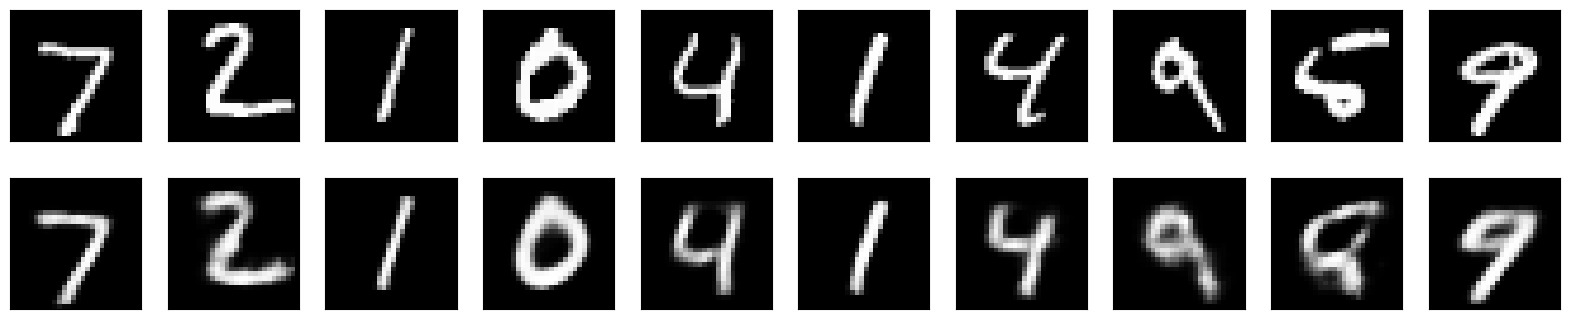

In [11]:
# bottleneck size = 8
autoencoder_8 = auto_model(8)
model_eval(autoencoder_8, x_train, x_test)

100%|██████████| 20/20 [01:34<00:00,  4.72s/epoch, loss=0.0972, val_loss=0.0972]


313/313 [==============================] - 1s 4ms/step


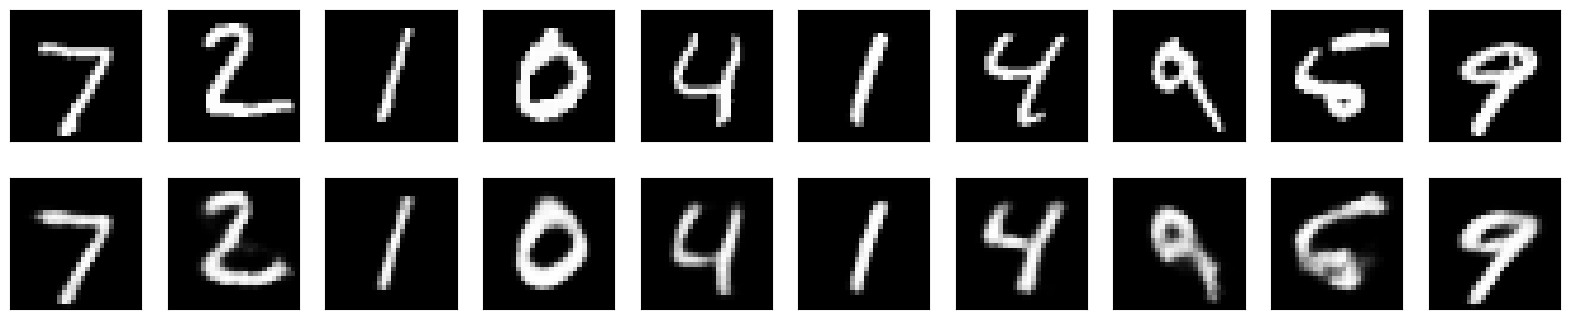

In [12]:
# bottleneck size = 16
autoencoder_16 = auto_model(16)
model_eval(autoencoder_16, x_train, x_test)

100%|██████████| 20/20 [01:31<00:00,  4.57s/epoch, loss=0.0775, val_loss=0.0772]

 25/313 [=>............................] - ETA: 0s 

313/313 [==============================] - 1s 2ms/step


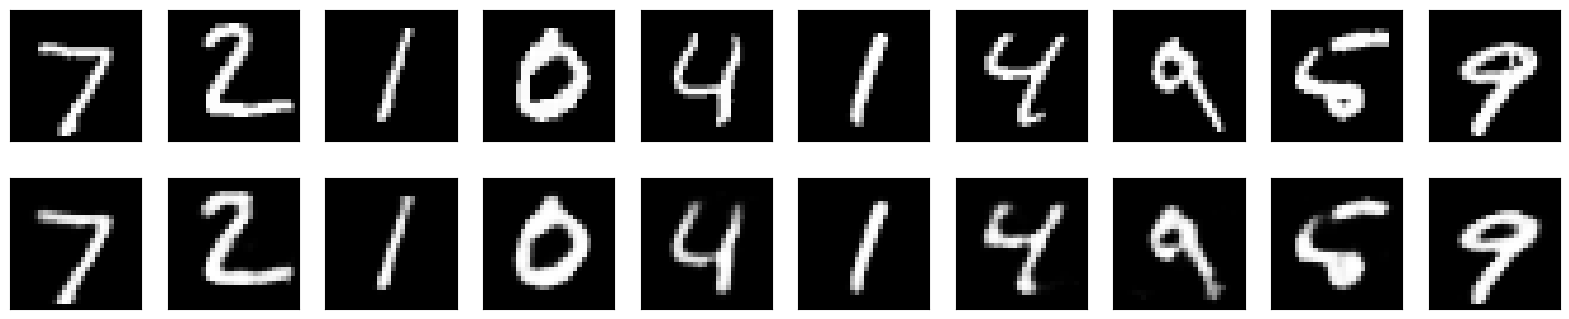

In [13]:
# bottleneck size = 64
autoencoder_64 = auto_model(64)
model_eval(autoencoder_64, x_train, x_test)

In [14]:
from tqdm import tqdm
from keras.callbacks import Callback
class tqdm_cb(Callback):
    def __init__(self, total):
        super().__init__()
        self.total = total
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.total, desc='Training model')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(loss=logs['loss'], accuracy=logs['accuracy'])

    def on_train_end(self, logs=None):
        self.pbar.close()

def run_test_harness(encoder_model, input_size):
    # load dataset
    trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)
    # process data
    trainX, testX = data_process(trainX, testX)
    encoded_imgs_train = encoder_model.predict(trainX)
    encoded_imgs_test = encoder_model.predict(testX)
    # define model
    model = classification_model(input_size)
    history = model.fit(encoded_imgs_train, trainY, epochs=100, batch_size=64, validation_data=(encoded_imgs_test, testY), verbose=0, callbacks=[tqdm_cb(100)])
    # evaluate model
    _, acc = model.evaluate(encoded_imgs_test, testY, verbose=0)
    print('> Accuracy: %.3f' % (acc * 100.0))
    diagnostic_plots(history)

In [15]:
def run_test_og(input_size):
    # load dataset
    trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(mnist)
    # process data
    trainX, testX = data_process(trainX, testX)
    # define model
    model = classification_model(input_size)
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0, callbacks=[tqdm_cb(100)])
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> Accuracy: %.3f' % (acc * 100.0))
    diagnostic_plots(history)

313/313 [==============================] - 1s 2ms/step


Training model: 100%|██████████| 100/100 [03:40<00:00,  2.21s/it, accuracy=0.943, loss=0.201]


> Accuracy: 93.880


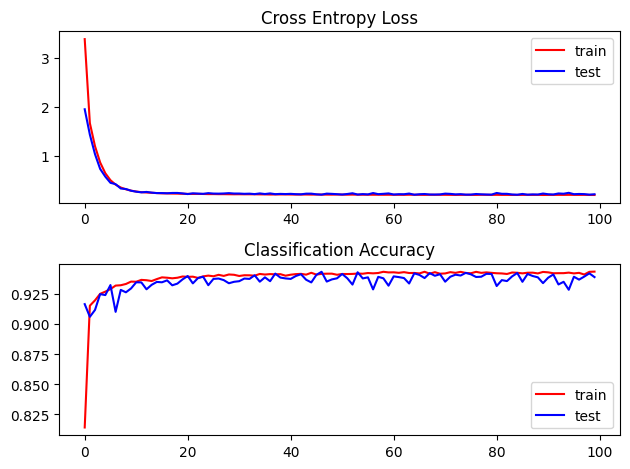

In [16]:
# classification training
# bottleneck size = 8
encoder_8 = Model(autoencoder_8.input, autoencoder_8.layers[-4].output)
run_test_harness(encoder_8, input_size=8)

313/313 [==============================] - 1s 2ms/step


Training model: 100%|██████████| 100/100 [03:44<00:00,  2.24s/it, accuracy=0.96, loss=0.157] 


> Accuracy: 95.500


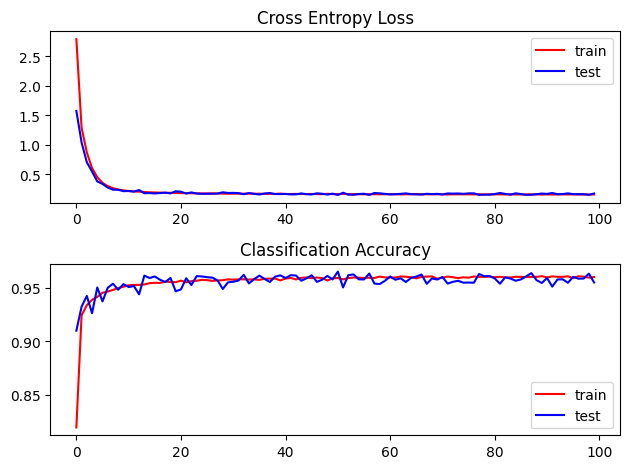

In [19]:
# classification training
# bottleneck size = 16
encoder_16 = Model(autoencoder_16.input, autoencoder_16.layers[-4].output)
run_test_harness(encoder_16, input_size=16)

313/313 [==============================] - 1s 2ms/step


Training model: 100%|██████████| 100/100 [03:53<00:00,  2.33s/it, accuracy=0.96, loss=0.182]


> Accuracy: 95.770


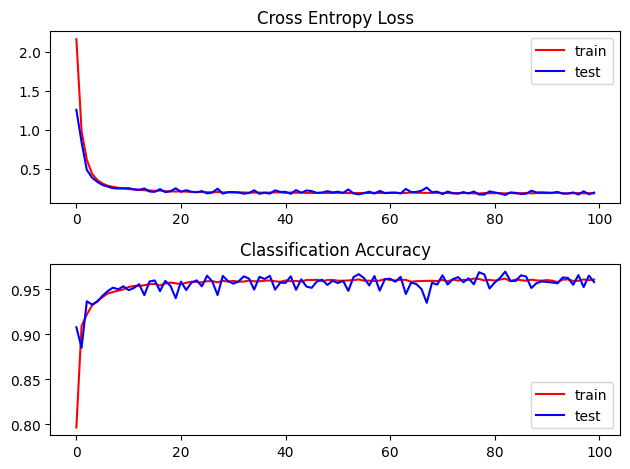

In [20]:
# classification training
# bottleneck size = 64
encoder_64 = Model(autoencoder_64.input, autoencoder_64.layers[-4].output)
run_test_harness(encoder_64, input_size=64)

Training model: 100%|██████████| 100/100 [05:12<00:00,  3.13s/it, accuracy=0.966, loss=0.193]


> Accuracy: 96.850


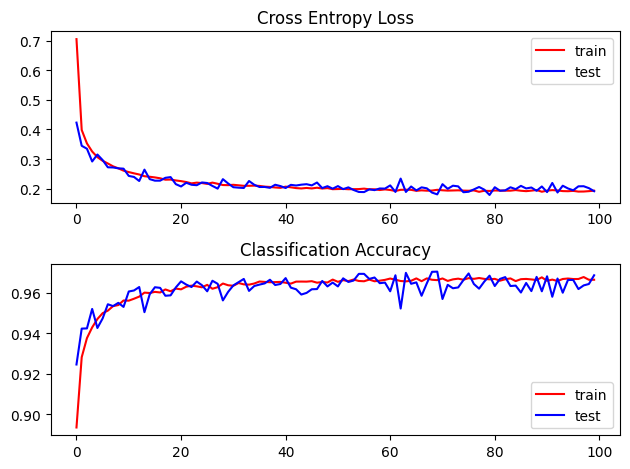

In [21]:
# classification without encoding
run_test_og(784)